In [4]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time
import torch.nn.functional as F

In [5]:
Root_dir = "D:/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "D:/New Plant Diseases Dataset(Augmented)/test"
Diseases_classes = os.listdir(train_dir)

In [6]:
test = datasets.ImageFolder(os.path.join(Root_dir, 'test'), transform= transforms.ToTensor())

In [7]:
class_names = test.classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# resnet architecture 
class CNN_NeuralNet(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) 
        self.conv4 = ConvBlock(256, 512, pool=True)
        
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, x): # x is the loaded batch
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [9]:
loaded_model18 = torchvision.models.resnet18()
num_ftrs = loaded_model18.fc.in_features
loaded_model18.fc = nn.Linear(num_ftrs, len(class_names))
loaded_model18.load_state_dict(torch.load('data/resnet18/resnet18_model.pth'))
# loaded_model = CNN_NeuralNet(3, len(class_names))
# loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model18.to(device)
loaded_model18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
loaded_model50 = torchvision.models.resnet50()
num_ftrs = loaded_model50.fc.in_features
loaded_model50.fc = nn.Linear(num_ftrs, len(class_names))
loaded_model50.load_state_dict(torch.load('data/resnet50/resnet50(2)_model.pth'))
# loaded_model = CNN_NeuralNet(3, len(class_names))
# loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model50.to(device)
loaded_model50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# loaded_model = torchvision.models.resnet18()
# num_ftrs = loaded_model.fc.in_features
# loaded_model.fc = nn.Linear(num_ftrs, len(class_names))
# loaded_model.load_state_dict(torch.load('data/resnet18/resnet18_model.pth'))
loaded_model_custom = CNN_NeuralNet(3, len(class_names))
loaded_model_custom.load_state_dict(torch.load('model.pth'))
loaded_model_custom.to(device)
loaded_model_custom.eval()

CNN_NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [12]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    # xb = to_device(img.unsqueeze(0), device)
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return preds[0].item()

In [15]:
all_acc = {}
correct18 = 0
correct50 = 0
correct_custom = 0
for i in range(len(test)):
    img, label = test[i]
    if predict_image(img, loaded_model18) == label:
        correct18 += 1
    if predict_image(img, loaded_model50) == label:
        correct50 += 1
    if predict_image(img, loaded_model_custom) == label:
        correct_custom += 1

all_acc["ResNet18"] = (correct18/len(test))
all_acc['ResNet50'] = (correct50/len(test))
all_acc['Custom'] = (correct_custom/len(test))

In [ ]:

print(all_acc)

{'ResNet18': 0.041820768136557614, 'ResNet50': 0.02631578947368421, 'Custom': 0.99900426742532}


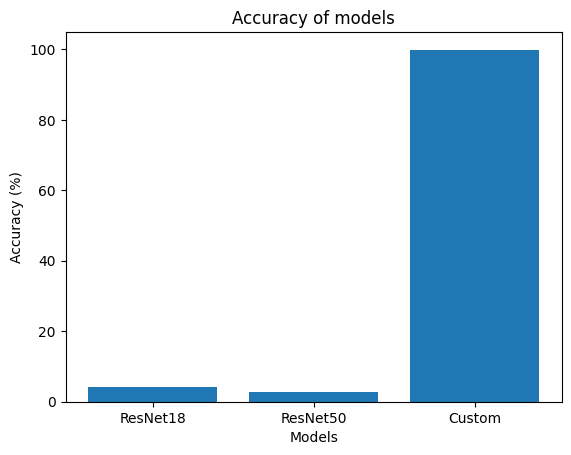

In [20]:
labels = []
vals = []
for k, v in all_acc.items():
    labels.append(k)
    vals.append(v*100)

plt.bar(labels, vals)
plt.title('Accuracy of models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.show;